## Classify with One VS All

In [148]:
import numpy as np
import scipy

# to save data
import pickle

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics.pairwise import pairwise_kernels
from scipy.optimize import minimize
from scipy.spatial.distance import hamming

import matplotlib.pyplot as plt
%matplotlib inline

from mySVM_class import *


In [151]:
def m_classes(l,n,m):
    
    #l: samples per class
    #n: dimension
    #m: number of classes
    
    centers = 20*np.random.rand(m,n)-10 #create the centers of the classes
    data = np.zeros((1, n))
    labels = np.zeros(l*m)
    for i in range(m):
        center = centers[i]
        # print(np.shape(data), np.shape(np.random.normal(loc=center, scale=1.0, size=(l, n))))
        
        data = np.concatenate((data,np.random.normal(loc=center, scale=1.0, size=(l, n))), axis = 0)
        
    for i in range(m):
        labels[(i*l):((i+1)*l)]=i 
    
    return data[1:], labels, centers

In [266]:
l=400;
n=10;
m=10;
toy_data, toy_labels, toy_centers = m_classes(l, n, m)
# toy_data_set

In [271]:
ecoc_labels, list_supp_ind, list_alpha, list_b, list_w, list_kernel, code_words, barycenters =oneVSall(toy_data[::2], toy_labels[::2], num_classifiers=m)

[ 1.08195634  1.08389043] -8.12832395877
[-1.80498942 -0.68112318] 7.81758592176
[ 0.12871504 -0.17214924] -0.275648321438


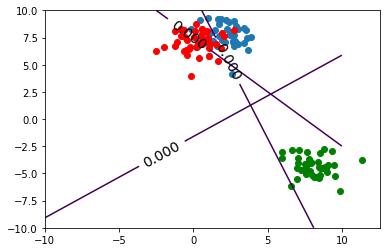

In [246]:
plt.scatter(toy_centers[:,0],  toy_centers[:,1], s=100, facecolors = 'none')
plt.scatter(toy_data[:l, 0], toy_data[:l, 1])
plt.scatter(toy_data[l:2*l, 0], toy_data[l:2*l, 1], facecolors='red')
plt.scatter(toy_data[2*l:3*l, 0], toy_data[2*l:3*l, 1], facecolors='green')

xs = np.linspace(-10, 10, 100)
ys = np.linspace(-10, 10, 100)
X, Y = np.meshgrid(xs, ys)

for i in range(m):
    np.dot(list_w[i],[1,1])
    print(list_w[i], list_b[i])
    Z = np.array([[ np.dot(list_w[i],np.array([x,y]))+list_b[i] for x in xs] for y in ys])
    Z = np.reshape(Z, (np.shape(Z)[0], np.shape(Z)[1]))
    #plt.plot([0, list_b[2]], [[1,1], np.dot(list_w[2],[1,1])+list_b[0]], 'k-', color = 'r
    CS = plt.contour(X, Y, Z, levels = [0])
    plt.clabel(CS, colors = 'k', fontsize=14)


In [247]:
toy_labels

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.])

In [270]:
predicted_labels = predict_oneVSall(toy_data[1::2], toy_data[::2], ecoc_labels, list_supp_ind, list_alpha, list_b, list_kernel, code_words, barycenters, num_classifiers=m)
print("number of correctly classified labels: ", sum(predicted_labels.astype(int)==toy_labels[1::2].astype(int)), 
      " out of ", np.shape(toy_data[1::2])[0]);
predicted_labels

number of correctly classified labels:  2000  out of  2000


array([ 0.,  0.,  0., ...,  9.,  9.,  9.])

In [86]:
train = pd.read_csv('Data/train.csv')

In [292]:
images = ["%s%s" %("pixel",pixel_no) for pixel_no in range(0,28**2)]
train_images = np.array(train[images], dtype=np.float)/100

train_labels = np.array(train['label'])
#label0 = np.array([1 if i==0 else -1 for i in train_labels])
len(train_images)

42000

In [303]:
def oneVSall(labeled_data, labels, num_classifiers=10, kernel=scalar_product, penalty=10, list_sigma=[0.005]*15):
    # 
    labels=labels.astype(int);
    l=np.shape(labeled_data)[0];
    n=np.shape(labeled_data)[1];
    #num_classifiers=3;
    oneVSall_labels=np.zeros((l,num_classifiers));
    
    # define code_word matrix, the ith row corresponds to the number i
    # each column corresponds to a classifier that will have to be trained
    code_words=2*np.identity(num_classifiers)-1;
    
    # up until now training data has labels from 0 to 9
    # now these are replaced by the 15 digit string given by code_words
    for j in range(l):
        oneVSall_labels[j]=code_words[labels[j]];
    
    list_supp_ind = [];
    list_alpha =[];
    list_b =[];
    list_kernel=[];
    list_w=[];
    
    # print(oneVSall_labels)
    
    # class an svm object for each classifier
    # here would be the possibility to parallelize
    for classifier in range(num_classifiers):
        svm=mySVM(kernel=kernel, penalty=penalty, sigma=list_sigma[classifier]);
        svm.fit(labeled_data, oneVSall_labels[:,classifier]);
        list_supp_ind.append(svm.supp_indices);
        list_alpha.append(svm.alpha);
        list_b.append(svm.b);
        list_kernel.append(svm.kernel);
        # list_w.append(svm.w)
        
    # compute barycenters of the points of each label
    barycenters = np.zeros((num_classifiers,n));
    
    for i in range(num_classifiers):
        ind = labels == i
        barycenters[i] = np.mean(labeled_data[ind], axis=0)
        
    # pickle dump to save and call saved objects    
    # pickle.dump((oneVSall_labels, list_supp_ind, list_alpha, list_b, list_kernel, code_words, barycenters), open( "trained_oneVSall_"+str(number_of_im)+".dat", "wb" ))
    
    # now I need to call a binary classifier for each column of ecoc_labels
    # from decision functions we get seperating hyperplanes, margin, ... 
    # return those
    
    
    return oneVSall_labels, list_supp_ind, list_alpha, list_b, list_kernel, code_words, barycenters;

In [304]:
number_of_im = 100;
train_images_test = train_images[:number_of_im]
train_labels_test = train_labels[:number_of_im]
np.shape(train_images_test)[1]

784

In [305]:
# call classifier with pickle.load
oneVSall_labels, list_supp_ind, list_alpha, list_b, list_kernel, code_words, barycenters=oneVSall(train_images_test, train_labels_test, kernel = gaussian_kernel)
# oneVSall_labels, list_supp_ind, list_alpha, list_b, list_kernel, code_words, barycenters=pickle.load(open ("trained_oneVSall_"+str(number_of_im)+".dat", "rb"))


In [306]:
# suppose we have an unlabeled data point
def predict_oneVSall(unlabeled_data, labeled_data, oneVSall_labels, list_supp_ind, 
                     list_alpha, list_b, list_kernel, code_words, barycenters, num_classifiers=10):
    # every row is one data point
    # number of rows = # of data points
    #num_classifiers=3;
    
    l=np.shape(unlabeled_data)[0];
    new_labels=np.zeros((l,num_classifiers));
    
    temp_label_ind=[];
    final_labels = np.array(['inf']*l).astype(float);
    

    
    for classifier in range(num_classifiers):
        a_supp = list_alpha[classifier][list_supp_ind[classifier]];
        oneVSall_labels_supp = oneVSall_labels[list_supp_ind[classifier],classifier]
        a_times_labels=np.multiply(a_supp, oneVSall_labels_supp)
        
        for i in range(l):
            # i_th row of kernel matrix k
            k=np.array([list_kernel[classifier](unlabeled_data[i],y) for y in labeled_data[list_supp_ind[classifier]]])
            
            # list of lists with 15 entries, one per classifier
            new_labels[i][classifier]=np.sign(np.dot(a_times_labels,k)+list_b[classifier]);
    
    for i in range(l):
        ham_dist = [hamming(new_labels[i], code_words[j]) for j in range(num_classifiers)]
        temp_label_ind = [j for j in range(len(ham_dist)) if ham_dist[j] == min(ham_dist)]
        # print(type(temp_label_ind[0]))
        if len(temp_label_ind)!=1:
            print("Attention, data point could not be uniquely classified, index " 
                  + str(i) + " possible classification " + str(temp_label_ind));
            
            # ask which barycenter is closest out of temp_label_ind
            final_labels[i] = np.min(np.argmin([np.linalg.norm(unlabeled_data[i]-barycenters[k]) for k in temp_label_ind]))
            
        else:
            final_labels[i] = ham_dist.index(min(ham_dist));
        
   
    return final_labels;
    

In [307]:
# "unknown" data to be classified
number_of_test_data = 100
test_data = train_images[number_of_im:number_of_im+number_of_test_data]

# call predict function
predicted_labels_test=predict_oneVSall(train_images[number_of_im:number_of_im+number_of_test_data], 
                                       train_images[:number_of_im], oneVSall_labels, list_supp_ind, list_alpha, 
                                       list_b, list_kernel, code_words, barycenters)
predicted_labels_test = predicted_labels_test.astype(float)
# print("predicted labels: ", predicted_labels_test)

# get actual labels
train_labels_test=train_labels[number_of_im:number_of_im+number_of_test_data]
train_labels_test = train_labels_test.astype(float)
# print("actual labels: ", train_labels_test)

print("number of correctly classified labels: ", sum(predicted_labels_test.astype(int)==train_labels_test.astype(int)), 
      " out of ", number_of_test_data);

# check if there is are a couple of classifiers who make more mistakes than others
# then we could possibly change some of the parameters

Attention, data point could not be uniquely classified, index 0 possible classification [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Attention, data point could not be uniquely classified, index 1 possible classification [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Attention, data point could not be uniquely classified, index 2 possible classification [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Attention, data point could not be uniquely classified, index 4 possible classification [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Attention, data point could not be uniquely classified, index 6 possible classification [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Attention, data point could not be uniquely classified, index 7 possible classification [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Attention, data point could not be uniquely classified, index 8 possible classification [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Attention, data point could not be uniquely classified, index 11 possible classification [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Attention, data point could not be uniquely cla

4